This is an approach to the Quora Insincere Questions Classification competition on Kaggle using the features based on the distribution of scores from a word counting approach in my MCS Thesis [Compact Features for Sentiment Analysis'](http://lgaud.github.io/Papers/Thesis_CompactFeaturesForSentimentAnalysis.pdf), also published in a  [Paper from Canadian AI 2011)](http://lgaud.github.io/Papers/CompactFeaturesForSentimentAnalysis.pdf)

My original implementation was in Java (using Weka and other APIs), and I hadn't previously implemented in Python. I thought it would be worthwhile trying it out on this dataset, as it's a similar binary problem as the problems I looked at in my thesis, and the approach worked relatively well on noisy texts. I don't expect it to perform amazingly on it's own but it may be useful as part of an ensemble.

I've just implemented here using the parameters I found worked relatively well across the problems I looked at in my thesis and haven't made an effort to tune it.
Params
In my thesis for sentiment (and also subjectivity, agreement, and pleasantness), I focused on using 25 bins with Naive Bayes and SVM classifiers, and I used precision to score (count in positive docs / total count)

In [ ]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
from sklearn.pipeline import Pipeline

original_train = pd.read_csv('../input/train.csv')

val = original_train.sample(frac=0.2, random_state=1234)
train = original_train.drop(val.index)
sample = train.sample(frac=0.1, random_state=42) # Small sample of the training set for testing code more quickly
print(len(val), len(train), len(sample))
del original_train

In [ ]:
sample.head()

In [ ]:
# Implement as a subclass of scikit-learn's count vectorizer
class HistogramVectorizer(CountVectorizer):
    def __init__(self, input='content', encoding='utf-8',
                 decode_error='strict', strip_accents=None, lowercase=True,
                 preprocessor=None, tokenizer=None, analyzer='word',
                 stop_words=None, token_pattern=r"(?u)\b\w\w+\b",
                 ngram_range=(1, 1), max_df=1.0, min_df=1,
                 max_features=None, vocabulary=None, binary=False,
                 dtype=np.float64, positive_class_label=1, bins=25):
        """See CountVectorizer for params
        positive_class_label: The label that specifies the positive class, used in fit
        bins: the number of features to generate """ 
        super(HistogramVectorizer, self).__init__(input=input, encoding=encoding, decode_error=decode_error,
            strip_accents=strip_accents, lowercase=lowercase,
            preprocessor=preprocessor, tokenizer=tokenizer, analyzer=analyzer,
            stop_words=stop_words, token_pattern=token_pattern,
            ngram_range=ngram_range, max_df=max_df, min_df=min_df,
            max_features=max_features, vocabulary=vocabulary, binary=binary,
            dtype=dtype)
        self.positive_class_label = positive_class_label
        self.bins = bins
        
    def fit(self, raw_documents, y):
        X = super(HistogramVectorizer, self).fit_transform(raw_documents)
        
        total_counts = np.sum(X, axis=0)
        pos = super(HistogramVectorizer, self).transform(raw_documents[y == self.positive_class_label])
        positive_counts = np.sum(pos, axis=0)
        self.precision_scores = positive_counts / total_counts

        return self
        
    def transform(self, raw_documents, copy=True):
        X = super(HistogramVectorizer, self).transform(raw_documents)
        docs, words = X.shape
        ranges = np.linspace(0, 1, num=self.bins)
        score_counts = np.zeros((docs, self.bins))

        # Todo look at vectorizing
        for doc_index in range(0, docs):
            indices = X[doc_index,:].nonzero()
            for word_index in indices[1]:    
                score = self.precision_scores[0, word_index]
                bin_index = np.searchsorted(ranges, score)
                score_counts[doc_index, bin_index] += 1
        
        normalized = score_counts / np.sum(score_counts, axis=1)[:,None]
        return np.nan_to_num(normalized)
            

In [ ]:
vectorizer = HistogramVectorizer(min_df=2, max_df=0.5)
classifier = GaussianNB()
train_df = train
vectorizer.fit(train_df["question_text"], train_df["target"])
train_features = vectorizer.transform(train_df["question_text"])
classifier.fit(train_features, train_df["target"])
train_preds = classifier.predict(train_features)

# Training set performance
print(accuracy_score(train_preds, train_df["target"]))
print(f1_score(train_preds, train_df["target"]))

In [ ]:
val_features = vectorizer.transform(val["question_text"])
val_preds = classifier.predict(val_features)

print(accuracy_score(val_preds, val["target"]))
print(f1_score(val_preds, val["target"]))

So on it's own this isn't performing terribly well, but maybe with more tweaking it might be useful as part of an ensemble.

# Visualizing how documents are represented

In [120]:
pos = vectorizer.transform(val[val["target"] == 1]["question_text"])
neg = vectorizer.transform(val[val["target"] == 0]["question_text"])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


(0, 1)

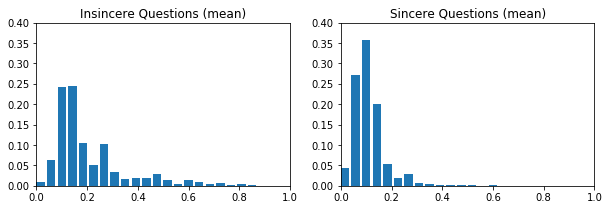

In [121]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

mean_pos = pos.mean(axis=0)
mean_neg = neg.mean(axis=0)
bar_width = 1/30
bins = np.linspace(0, 1, 25)

y_dims = (0, 0.4)
x_dims = (0, 1)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))

axes[0].set_title('Insincere Questions (mean)')
axes[0].bar(bins, mean_pos, width=bar_width, align='edge')
axes[0].set_ylim(y_dims)
axes[0].set_xlim(x_dims)
axes[1].set_title('Sincere Questions (mean)')
axes[1].bar(bins, mean_neg, width=bar_width, align='edge')
axes[1].set_ylim(y_dims)
axes[1].set_xlim(x_dims)


(0, 1)

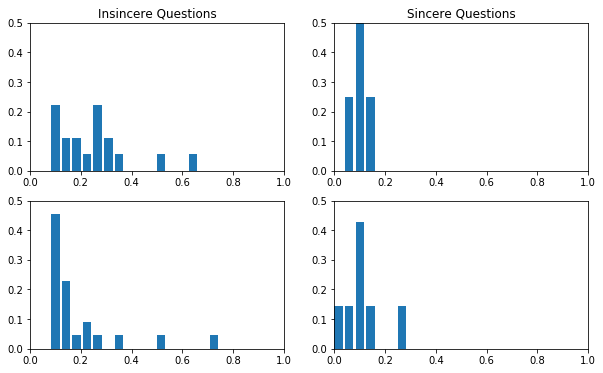

In [122]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,6))
y_dims = (0, 0.5)
axes[0, 0].set_title('Insincere Questions')
axes[0, 0].bar(bins, pos[0], width=bar_width, align='edge')
axes[0, 0].set_ylim(y_dims)
axes[0, 0].set_xlim(x_dims)
axes[1, 0].bar(bins, pos[1], width=bar_width, align='edge')
axes[1, 0].set_ylim(y_dims)
axes[1, 0].set_xlim(x_dims)
axes[0, 1].set_title('Sincere Questions')
axes[0, 1].bar(bins, neg[0], width=bar_width, align='edge')
axes[0, 1].set_ylim(y_dims)
axes[0, 1].set_xlim(x_dims)
axes[1, 1].bar(bins, neg[1], width=bar_width, align='edge')
axes[1, 1].set_ylim(y_dims)
axes[1, 1].set_xlim(x_dims)

The insincere questions have a distribution that's shifted a little to the right. I notice that the full distribution isn't really being used, which I believe is due to this dataset being quite imbalanced and the scoring method I used here (precision) not really accounting for that.